<a href="https://colab.research.google.com/github/lsellers11/Black-Holes/blob/main/Higgs_Kerr2D_Tortoise_no_omega.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/usr/local/lib/python3.6/dist-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


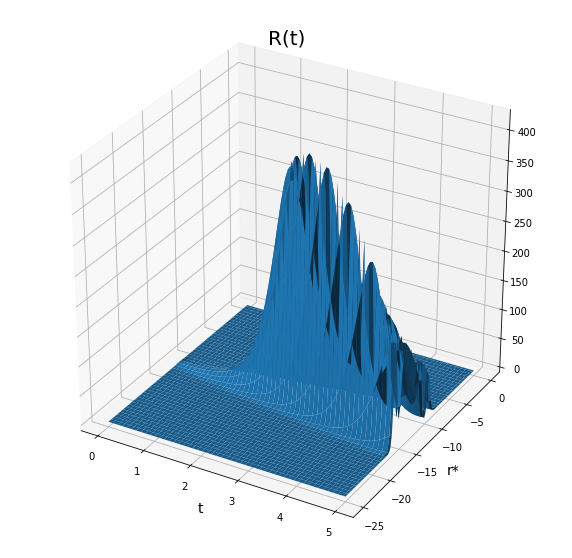

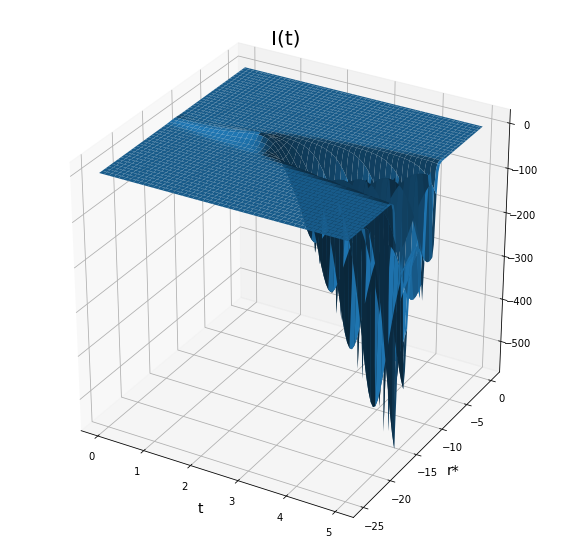

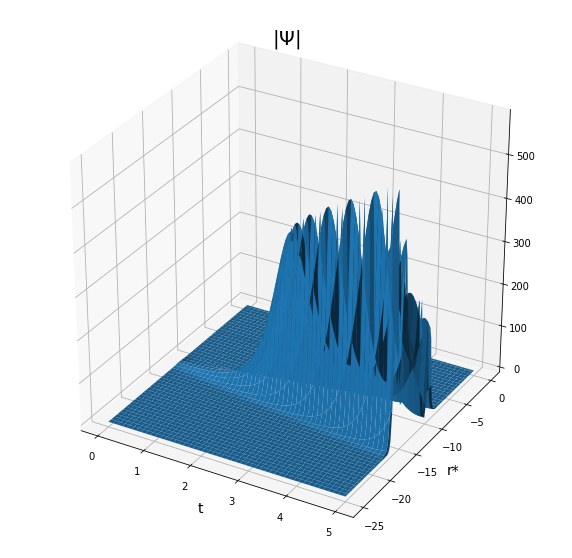

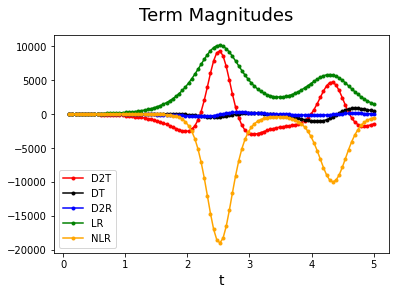

rmin =  1.1413114741657848
rmax =  101.0000663333249
rplus =  1.141067359796659
mOmeghaH =  3.036630546173428
Avg w =  3.659031443592818
Max mode at f =  -0.396


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


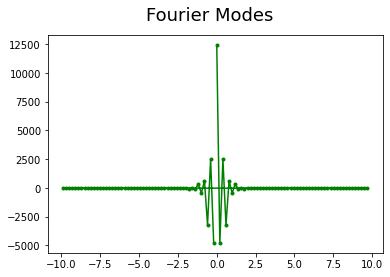

In [ ]:
import numpy as np
from sympy import *
import scipy.sparse as sp
import scipy.sparse.linalg as spla
from scipy import integrate as scint
import scipy.optimize as scopt
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d, Axes3D
import time
from timeit import default_timer as timer
from random import randint
from scipy.fft import fft, fftfreq

### Description
#
## Finite Difference solver for Klein Gordon Equation of Abelian Higgs Field on a Kerr BH Spacetime Background in (2+1) D
#
# Seperation Ansatz psi ~ psi(r, t) * exp(i*m*phi)
#
# Use Tortoise Coordinate r* = rplus**2 * {ln[abs(r-rplus)] - ln[abs(r-rmin)]} / (rplus - rmin)
#
# So rplus -> -infinity; rmin -> infinity; infinity -> 0

## Black Hole Parameters
G = 1.0;
M = 1.0;
a = 0.99;

### Grid Parameters
Nt = 100;
Nrtort = 100;
Lt = 5;
Lrtort = 25*M;

tgrid, dt = np.linspace(0, Lt, Nt, retstep=True);
rtortgrid, drtort = np.linspace(-1*Lrtort, 0, Nrtort, retstep=True);

### Physical Parameters

## Orbital Parameters
m = 7;
w = 0;

## Higgs Potential
#
# Coupling Constant
lamb = .4;
# Vaccuum Expectation Value (0 for restored symmetry)
v2 = 0.5;

# Theta Slice to Analyze
theta = np.pi/2;

# Outer Event Horizon, Ergoregion, and EH Angular Velocity
rplus = G*M + ((G**2)*(M**2) - a**2)**(1/2); 
rmin = G*M - ((G**2)*(M**2) - a**2)**(1/2);
rerg = G*M + ((G**2*M**2) - a**2*np.cos(theta)**2)**(1/2);
OmegaH = a / (rplus**2 + a**2);

### Kerr Spacetime Variables

## Define Delta(r)
def Delt(x):
  return x**2 - 2*G*M*x + a**2;

## Define rho**2(r)
def rhosq(x):
  return x**2 + a**2*np.cos(theta)**2;

### Toroise Coordinates

## Tortoise Transformation
def torttrans(r):

  # for dr/dr* = Delta / rplus^2
  return rplus**2 * (np.log(abs(r - rplus)) - np.log(abs(r-rmin))) / (rplus - rmin); # for dr/dr* = Delta

  # # for dr/dr* = Delta / r**2
  # return r + M*np.log(Delt(r)) + (2*M**2 - a**2) / 2 / (M**2 - a**2)**(1/2) * np.log((r-rplus)/(r-rmin));

## Inverse Transformation (Only works for r > rplus, or rtort < 0) This is the physical region anyway. 
def rfromtort(xtort):
  return (np.exp(xtort * (rplus-rmin))*rmin - rplus) / (np.exp(xtort * (rplus-rmin)) - 1);

### Finite Differences Functions
def Dt2(Rk1n0, Rk0n0, R1kn0): 
  return (Rk1n0 - 2*Rk0n0 + R1kn0) / dt**2;

def Dr2(Rk0n1, Rk0n0, Rk01n):
  return (Rk0n1 - 2*Rk0n0 + Rk01n) / drtort**2;

def Dt(Rk1n0, R1kn0):
  return (Rk1n0 - R1kn0) / (2*dt);

## For w estimation later, Fwd Euler Derivative
def fwdDt(Rk1n0, Rk0n0):
  return (Rk1n0 - Rk0n0) / dt

def Dr(Rk0n1, Rk01n):
  return (Rk0n1 - Rk01n) / (2*drtort)

### Define Terms for Keeping track of Term Magnitudes

# def D2T(Rk1n0, Rk0n0, R1kn0, r, Delta):
#   return abs((-1/rplus**4)*((r**2 + a**2)**2 - Delta*(a**2)*np.sin(theta)**2)*Dt2(Rk1n0, Rk0n0, R1kn0));

# def DT(Ik1n0, I1kn0, r):
#   return abs((4*a*M*r / rplus**4)*Dt(Ik1n0, I1kn0));

# def D2R(Rk0n1, Rk0n0, Rk01n):
#   return abs(Dr2(Rk0n1, Rk0n0, Rk01n));

# def LR(Rk0n0, Delta):
#   return abs(-1*(1/rplus**4) * ((Delta - (a**2)*np.sin(theta)**2) / (np.sin(theta)**2))*(m**2)*Rk0n0);

# def NLR(Rk0n0, Ik0n0, Delta):
#   return abs(-1*Delta*rho2*(lamb / 2)*((Rk0n0**2 + Ik0n0**2) - v2)*Rk0n0 / rplus**4);

## Terms w/ Signs
def D2T(Rk1n0, Rk0n0, R1kn0, r, Delta):
  return (-1/rplus**4)*((r**2 + a**2)**2 - Delta*(a**2)*np.sin(theta)**2)*Dt2(Rk1n0, Rk0n0, R1kn0);

def DT(Ik1n0, I1kn0, r):
  return (4*a*M*r / rplus**4)*Dt(Ik1n0, I1kn0);

def D2R(Rk0n1, Rk0n0, Rk01n):
  return Dr2(Rk0n1, Rk0n0, Rk01n);

def LR(Rk0n0, Delta):
  return -1*(1/rplus**4) * ((Delta - (a**2)*np.sin(theta)**2) / (np.sin(theta)**2))*(m**2)*Rk0n0;

def NLR(Rk0n0, Ik0n0, Delta):
  return -1*Delta*rho2*(lamb / 2)*((Rk0n0**2 + Ik0n0**2) - v2)*Rk0n0 / rplus**4;

### Coupled PDE Field Equations for Real and Imaginary part of Psi
def geteqs(Rk0n0, R1kn0, Rk0n1, Rk01n, Ik0n0, I1kn0, Ik0n1, Ik01n, Delta, rho2, r):

  def equations(p):
    x, y = p;

    Req = (-1/rplus**4)*((r**2 + a**2)**2 - Delta*(a**2)*np.sin(theta)**2)*Dt2(x, Rk0n0, R1kn0) + (4*a*M*r / rplus**4)*Dt(y, I1kn0) + Dr2(Rk0n1, Rk0n0, Rk01n) - (1/rplus**4) * ((Delta - (a**2)*np.sin(theta)**2) / (np.sin(theta)**2))*(m**2)*Rk0n0 - Delta*rho2*(lamb / 2)*((Rk0n0**2 + Ik0n0**2) - v2)*Rk0n0 / rplus**4;

    # #Linear
    # Req = (-1/rplus**4)*((r**2 + a**2)**2 - Delta*(a**2)*np.sin(theta)**2)*Dt2(x, Rk0n0, R1kn0) + (4*a*M*r / rplus**4)*Dt(y, I1kn0) + Dr2(Rk0n1, Rk0n0, Rk01n) - (1/rplus**4) * ((Delta - (a**2)*np.sin(theta)**2) / (np.sin(theta)**2))*(m**2)*Rk0n0 - Delta*rho2*(lamb / 2)*Rk0n0 / rplus**4;

    Ieq = (-1/rplus**4)*((r**2 + a**2)**2 - Delta*(a**2)*np.sin(theta)**2)*Dt2(y, Ik0n0, I1kn0) - (4*a*M*r / rplus**4)*Dt(x, R1kn0) + Dr2(Ik0n1, Ik0n0, Ik01n) - (1/rplus**4) * ((Delta - (a**2)*np.sin(theta)**2) / (np.sin(theta)**2))*(m**2)*Ik0n0 - Delta*rho2*(lamb / 2)*((Rk0n0**2 + Ik0n0**2) - v2)*Ik0n0 / rplus**4;

    # #Linear
    # Ieq = (-1/rplus**4)*((r**2 + a**2)**2 - Delta*(a**2)*np.sin(theta)**2)*Dt2(y, Ik0n0, I1kn0) - (4*a*M*r / rplus**4)*Dt(x, R1kn0) + Dr2(Ik0n1, Ik0n0, Ik01n) - (1/rplus**4) * ((Delta - (a**2)*np.sin(theta)**2) / (np.sin(theta)**2))*(m**2)*Ik0n0 - Delta*rho2*(lamb / 2)*Ik0n0 / rplus**4;

    return [Req, Ieq];

  return equations;

### Initialize R & I (Real and Imaginary parts of Psi)
R = np.zeros((Nrtort, Nt));
I = np.zeros((Nrtort, Nt));

### Initial Conditions

## R(r,0) & I(r,0)

# For Pulse Test
amp = 1;
sigma = drtort;
p0 = int(Nrtort/2) - 1;

# Initial Profiles
def fR(x):
  return amp*np.exp((-1*(x-rtortgrid[p0])**2) / (2*sigma)); # Pulse Test

def fI(x):
  return amp*np.exp((-1*(x-rtortgrid[p0])**2) / (2*sigma)); # Pulse Test

R[:, 0] = fR(rtortgrid);
I[:, 0] = fI(rtortgrid);

## d/dt R(r,0) & I(r,0)
def gR(x):
  return 0;

def gI(x):
  return 0;

### Boundary Conditions 

## @ Asymptotically Flat (Infinity)
RLrt = 0;
ILrt = 0;

R[Nrtort-1, :] = RLrt;
I[Nrtort-1, :] = ILrt;

### Equations to Solve Initial Conditions

## sub R1kn0 = x - 2*dt*gR(r)
## sub I1kn0 = y - 2*dt*gI(r)

def geteqs0(Rk0n0, Ik0n0, Rk0n1, Ik0n1, Rk01n, Ik01n, Delta, rho2, r):

  def equations(p):
    x, y = p;

    Req = (-1/rplus**4)*((r**2 + a**2)**2 - Delta*(a**2)*np.sin(theta)**2)*Dt2(x, Rk0n0, x - 2*dt*gR(r)) + (4*a*M*r / rplus**4)*Dt(y, y - 2*dt*gI(r)) + Dr2(Rk0n1, Rk0n0, Rk01n) - (1/rplus**4)*((Delta - a**2*np.sin(theta)**2) / (np.sin(theta)**2))*m**2*Rk0n0 - Delta*rho2*(lamb / 2)*((Rk0n0**2 + Ik0n0**2) - v2)*Rk0n0 / rplus**4;

    # Linear
    # Req = (-1/rplus**4)*((r**2 + a**2)**2 - Delta*(a**2)*np.sin(theta)**2)*Dt2(x, Rk0n0, x - 2*dt*gR(r)) + (4*a*M*r / rplus**4)*Dt(y, y - 2*dt*gI(r)) + Dr2(Rk0n1, Rk0n0, Rk01n) - (1/rplus**4)*((Delta - a**2*np.sin(theta)**2) / (np.sin(theta)**2))*m**2*Rk0n0 - Delta*rho2*(lamb / 2)*Rk0n0 / rplus**4;

    Ieq = (-1/rplus**4)*((r**2 + a**2)**2 - Delta*(a**2)*np.sin(theta)**2)*Dt2(y, Ik0n0, y - 2*dt*gI(r)) - (4*a*M*r / rplus**4)*Dt(x, x - 2*dt*gR(r)) + Dr2(Ik0n1, Ik0n0, Ik01n) - (1/rplus**4)*((Delta - a**2*np.sin(theta)**2) / (np.sin(theta)**2))*m**2*Ik0n0 - Delta*rho2*(lamb / 2)*((Rk0n0**2 + Ik0n0**2) - v2)*Ik0n0 / rplus**4;

    # Linear
    # Ieq = (-1/rplus**4)*((r**2 + a**2)**2 - Delta*(a**2)*np.sin(theta)**2)*Dt2(y, Ik0n0, y - 2*dt*gI(r)) - (4*a*M*r / rplus**4)*Dt(x, x - 2*dt*gR(r)) + Dr2(Ik0n1, Ik0n0, Ik01n) - (1/rplus**4)*((Delta - a**2*np.sin(theta)**2) / (np.sin(theta)**2))*m**2*Ik0n0 - Delta*rho2*(lamb / 2)*Ik0n0 / rplus**4;

    return [Req, Ieq];

  return equations;

### Equations to Solve Initial and Boundary Conditions Simulataneously 

vplus = rplus / (2*M);

## sub R1kn0 = Rk1n0 - 2*dt*gR(r)
## sub I1kn0 = Ik1n0 - 2*dt*gI(r)
## sub Rk01n = Rk0n1 - (2*dr / vplus) * ((Rk1n0 - R1kn0) / (2*dt) - m*Omega*Ik0n0)
## sub Ik01n = Ik0n1 - (2*dr / vplus) * ((Ik1n0 - I1kn0) / (2*dt) + m*Omega*Rk0n0)


def geteqs1(Rk0n0, Ik0n0, Rk0n1, Ik0n1, Delta, rho2, r):

  def equations(p):
    x, y = p;

    # Req = (-1/rplus**4)*((r**2 + a**2)**2 - Delta*(a**2)*np.sin(theta)**2)*Dt2(x, Rk0n0, x - 2*dt*gR(r)) + (4*a*M*r / rplus**4)*Dt(y, y - 2*dt*gI(r)) + Dr2(Rk0n1, Rk0n0, Rk0n1 - (2*drtort / vplus) * ((x - (x - 2*dt*gR(r))) / (2*dt) - m*OmegaH*Ik0n0)) - (1/rplus**4) * ((Delta - a**2*np.sin(theta)**2) / (np.sin(theta)**2))*m**2*Rk0n0 - Delta*rho2*(lamb / 2)*((Rk0n0**2 + Ik0n0**2) - v2)*Rk0n0/rplus**4;

    #Linear
    Req = (-1/rplus**4)*((r**2 + a**2)**2 - Delta*(a**2)*np.sin(theta)**2)*Dt2(x, Rk0n0, x - 2*dt*gR(r)) + (4*a*M*r / rplus**4)*Dt(y, y - 2*dt*gI(r)) + Dr2(Rk0n1, Rk0n0, Rk0n1 - (2*drtort / vplus) * ((x - (x - 2*dt*gR(r))) / (2*dt) - m*OmegaH*Ik0n0)) - (1/rplus**4) * ((Delta - a**2*np.sin(theta)**2) / (np.sin(theta)**2))*m**2*Rk0n0 - Delta*rho2*(lamb / 2)*Rk0n0/rplus**4;

    # Ieq = (-1/rplus**4)*((r**2 + a**2)**2 - Delta*(a**2)*np.sin(theta)**2)*Dt2(y, Ik0n0, y - 2*dt*gI(r)) - (4*a*M*r / rplus**4)*Dt(x, x - 2*dt*gR(r)) + Dr2(Ik0n1, Ik0n0, Ik0n1 - (2*drtort / vplus) * ((y - (y - 2*dt*gI(r))) / (2*dt) + m*OmegaH*Rk0n0)) - (1/rplus**4) * ((Delta - a**2*np.sin(theta)**2) / (np.sin(theta)**2))*m**2*Ik0n0 - Delta*rho2*(lamb / 2)*((Rk0n0**2 + Ik0n0**2) - v2)*Ik0n0/rplus**4;

    #Linear
    Ieq = (-1/rplus**4)*((r**2 + a**2)**2 - Delta*(a**2)*np.sin(theta)**2)*Dt2(y, Ik0n0, y - 2*dt*gI(r)) - (4*a*M*r / rplus**4)*Dt(x, x - 2*dt*gR(r)) + Dr2(Ik0n1, Ik0n0, Ik0n1 - (2*drtort / vplus) * ((y - (y - 2*dt*gI(r))) / (2*dt) + m*OmegaH*Rk0n0)) - (1/rplus**4) * ((Delta - a**2*np.sin(theta)**2) / (np.sin(theta)**2))*m**2*Ik0n0 - Delta*rho2*(lamb / 2)*Ik0n0/rplus**4;

    return [Req, Ieq];

  return equations;

### Equations to Solve Boundary Conditions

## sub Rk01n = Rk0n1 - (2*dr / vplus) * ((Rk1n0 - R1kn0) / (2*dt) - m*Omega*Ik0n0)
## sub Ik01n = Ik0n1 - (2*dr / vplus) * ((Ik1n0 - I1kn0) / (2*dt) + m*Omega*Rk0n0)

def geteqs2(Rk0n0, Ik0n0, R1kn0, I1kn0, Rk0n1, Ik0n1, Delta, rho2, r):

  def equations(p):
    x, y = p;

    Req = (-1/rplus**4)*((r**2 + a**2)**2 - Delta*(a**2)*np.sin(theta)**2)*Dt2(x, Rk0n0, R1kn0) + (4*a*M*r / rplus**4)*Dt(y, I1kn0) + Dr2(Rk0n1, Rk0n0, Rk0n1 - (2*drtort / vplus) * ((x - R1kn0) / (2*dt) - m*OmegaH*Ik0n0)) - (1/rplus**4)*((Delta - a**2*np.sin(theta)**2) / (np.sin(theta)**2))*m**2*Rk0n0 - Delta*rho2*(lamb / 2)*((Rk0n0**2 + Ik0n0**2) - v2)*Rk0n0 / rplus**4;

    # #Linear
    # Req = (-1/rplus**4)*((r**2 + a**2)**2 - Delta*(a**2)*np.sin(theta)**2)*Dt2(x, Rk0n0, R1kn0) + (4*a*M*r / rplus**4)*Dt(y, I1kn0) + Dr2(Rk0n1, Rk0n0, Rk0n1 - (2*drtort / vplus) * ((x - R1kn0) / (2*dt) - m*OmegaH*Ik0n0)) - (1/rplus**4)*((Delta - a**2*np.sin(theta)**2) / (np.sin(theta)**2))*m**2*Rk0n0 - Delta*rho2*(lamb / 2)*Rk0n0 / rplus**4;

    Ieq = (-1/rplus**4)*((r**2 + a**2)**2 - Delta*(a**2)*np.sin(theta)**2)*Dt2(y, Ik0n0, I1kn0) - (4*a*M*r / rplus**4)*Dt(x, R1kn0) + Dr2(Ik0n1, Ik0n0, Ik0n1 - (2*drtort / vplus) * ((y - I1kn0) / (2*dt) + m*OmegaH*Rk0n0)) - (1/rplus**4)*((Delta - a**2*np.sin(theta)**2) / (np.sin(theta)**2))*m**2*Ik0n0 - Delta*rho2*(lamb / 2)*((Rk0n0**2 + Ik0n0**2) - v2)*Ik0n0 / rplus**4;

    # #Linear
    # Ieq = (-1/rplus**4)*((r**2 + a**2)**2 - Delta*(a**2)*np.sin(theta)**2)*Dt2(y, Ik0n0, I1kn0) - (4*a*M*r / rplus**4)*Dt(x, R1kn0) + Dr2(Ik0n1, Ik0n0, Ik0n1 - (2*drtort / vplus) * ((y - I1kn0) / (2*dt) + m*OmegaH*Rk0n0)) - (1/rplus**4)*((Delta - a**2*np.sin(theta)**2) / (np.sin(theta)**2))*m**2*Ik0n0 - Delta*rho2*(lamb / 2)*Ik0n0 / rplus**4;

    return [Req, Ieq];

  return equations;

## Solve for R and I after 1st Time Step
i = 0;
for j in range(2, Nrtort + 1):

  if (Nrtort - j) != 0: # Not on Event Horizon 
    rtort = rtortgrid[Nrtort - j];
    r = rfromtort(rtort);

    Delta = Delt(r);
    rho2 = rhosq(r);

    Rk0n0 = R[Nrtort - j, i];
    Rk0n1 = R[Nrtort - j + 1, i];
    Rk01n = R[Nrtort - j - 1, i];

    Ik0n0 = I[Nrtort - j, i];
    Ik0n1 = I[Nrtort - j + 1, i];
    Ik01n = I[Nrtort - j - 1, i];

    eqs = geteqs0(Rk0n0, Ik0n0, Rk0n1, Ik0n1, Rk01n, Ik01n, Delta, rho2, r);

    R[Nrtort - j, i+1], I[Nrtort - j, i+1] = scopt.fsolve(eqs, (R[Nrtort - j, i], I[Nrtort - j, i]));

  if (Nrtort - j) == 0: # On Event Horizon
    rtort = rtortgrid[Nrtort - j];
    r = rfromtort(rtort);

    Delta = Delt(r);
    rho2 = rhosq(r);

    Rk0n0 = R[Nrtort - j, i];
    Rk0n1 = R[Nrtort - j + 1, i];

    Ik0n0 = I[Nrtort - j, i];
    Ik0n1 = I[Nrtort - j + 1, i];

    eqs = geteqs1(Rk0n0, Ik0n0, Rk0n1, Ik0n1, Delta, rho2, r);

    R[Nrtort - j, i+1], I[Nrtort - j, i+1] = scopt.fsolve(eqs, (R[Nrtort - j, i], I[Nrtort - j, i+1]));

# ## Plot Test for Initial Conditions
# Rs, T = np.meshgrid(tgrid, rtortgrid);
# fig1 = plt.figure(figsize=(10,10));
# ax1 = fig1.add_subplot(111, projection = '3d');
# ax1.plot_surface(Rs, T, R);

# fig2 = plt.figure(figsize=(10,10));
# ax2 = fig2.add_subplot(111, projection = '3d');
# ax2.plot_surface(Rs, T, I);

# plt.show()

### Define Term Vectors
D2Ts = np.zeros(Nt - 2);
DTs = np.zeros(Nt - 2);
D2Rs = np.zeros(Nt - 2);
LRs = np.zeros(Nt - 2);
NLRs = np.zeros(Nt - 2);

### Solve for Interior
for i in range(1, Nt-1):
  for j in range(2, Nrtort+1):
    
    if (Nrtort - j) != 0: # Not on event horizon
      rtort = rtortgrid[Nrtort - j];
      r = rfromtort(rtort);

      Delta = Delt(r);
      rho2 = rhosq(r);

      Rk0n0 = R[Nrtort - j, i];
      R1kn0 = R[Nrtort - j, i-1];
      Rk0n1 = R[Nrtort - j + 1, i];
      Rk01n = R[Nrtort - j - 1, i];

      Ik0n0 = I[Nrtort - j, i];
      I1kn0 = I[Nrtort - j, i-1];
      Ik0n1 = I[Nrtort - j + 1, i];
      Ik01n = I[Nrtort - j - 1, i];

      eqs = geteqs(Rk0n0, R1kn0, Rk0n1, Rk01n, Ik0n0, I1kn0, Ik0n1, Ik01n, Delta, rho2, r);

      R[Nrtort - j, i+1], I[Nrtort - j, i+1] = scopt.fsolve(eqs, (R[Nrtort - j, i], I[Nrtort - j, i]));

    if (Nrtort - j) == 0: # On Event Horizon
      rtort = rtortgrid[Nrtort - j];
      r = rfromtort(rtort);

      Delta = Delt(r);
      rho2 = rhosq(r);

      Rk0n0 = R[Nrtort - j, i];
      R1kn0 = R[Nrtort - j, i-1];
      Rk0n1 = R[Nrtort - j + 1, i];

      Ik0n0 = I[Nrtort - j, i];
      I1kn0 = I[Nrtort - j, i-1];
      Ik0n1 = I[Nrtort - j + 1, i];

      eqs = geteqs2(Rk0n0, Ik0n0, R1kn0, I1kn0, Rk0n1, Ik0n1, Delta, rho2, r);

      R[Nrtort - j, i+1], I[Nrtort - j, i+1] = scopt.fsolve(eqs, (R[Nrtort - j, i], I[Nrtort - j, i+1]));

    # For Term Magnitudes

    if (Nrtort - j) == int(Nrtort/2):

      Rk1n0 = R[Nrtort - j, i+1];
      Ik1n0 = I[Nrtort - j, i+1];

      D2Ts[i-1] = D2T(Rk1n0, Rk0n0, R1kn0, r, Delta);
      DTs[i-1] = DT(Ik1n0, I1kn0, r);
      D2Rs[i-1] = D2R(Rk0n1, Rk0n0, Rk01n);
      LRs[i-1] = LR(Rk0n0, Delta);
      NLRs[i-1] = NLR(Rk0n0, Ik0n0, Delta); 



### Plots

## R(t)
Rs, T = np.meshgrid(tgrid, rtortgrid);
fig1 = plt.figure(figsize=(10,10));
ax1 = fig1.add_subplot(111, projection = '3d');
ax1.set_xlabel('t', fontsize = 14.0);
ax1.set_ylabel('r*', fontsize = 14.0);
ax1.set_title('R(t)', fontsize = 20.0);
ax1.plot_surface(Rs, T, R);

## I(t)
fig2 = plt.figure(figsize=(10,10));
ax2 = fig2.add_subplot(111, projection = '3d');
ax2.set_xlabel('t', fontsize = 14.0);
ax2.set_ylabel('r*', fontsize = 14.0);
ax2.set_title('I(t)', fontsize = 20.0);
ax2.plot_surface(Rs, T, I);

## Calc Norm 
norm = np.zeros((Nrtort, Nt));
for i in range(Nrtort):
  for j in range(Nt):
    norm[i, j] = (R[i, j]**2 + I[i, j]**2)**(1/2);

## Norm**2(t)
fig3 = plt.figure(figsize=(10,10));
ax3 = fig3.add_subplot(111, projection = '3d');
ax3.set_xlabel('t', fontsize = 14.0);
ax3.set_ylabel('r*', fontsize = 14.0);
ax3.set_title('$|\Psi|$', fontsize = 20.0);
ax3.plot_surface(Rs, T, norm);

# # Turn R, I, and Norm2 into vectors
# Rv = np.zeros(Nr*Nt);
# Iv = np.zeros(Nr*Nt);
# Norm2v = np.zeros(Nr*Nt);
# for k in range(Nr*Nt):
#   i = k%Nr;
#   j = int((k-i)/Nr);
#   Rv[k] = R[i, j];
#   Iv[k] = I[i, j];
#   Norm2v[k] = Norm

## Term Magnitude Plot

fig = plt.figure();
ax = fig.add_subplot(111);
fig.suptitle("Term Magnitudes", fontsize = 18);

newtgrid = np.delete(tgrid, [0,1], None); 

ax.plot(newtgrid, D2Ts, '.-', color = 'red', label = 'D2T');
ax.plot(newtgrid, DTs, '.-', color = 'black', label = 'DT');
ax.plot(newtgrid, D2Rs, '.-', color = 'blue', label = 'D2R');
ax.plot(newtgrid, LRs, '.-', color = 'green', label = 'LR');
ax.plot(newtgrid, NLRs, '.-', color = 'orange', label = 'NLR');
ax.legend(loc = 'best');
ax.set_xlabel('t', fontsize = '14'); 

plt.show()

print('rmin = ', rfromtort(-25))
print('rmax = ', rfromtort(-0.01))
print('rplus = ', rplus)
mOmegaH = m*OmegaH;
print('mOmeghaH = ', mOmegaH)


### Frequency Domain Analysis
Rcrosssect = R[int(Nrtort/2)-1, :];

## Estimate Period Average
times = [];
for i in range(1, Nt-1):
  if fwdDt(Rcrosssect[i], Rcrosssect[i-1]) >= 0 and fwdDt(Rcrosssect[i+1], Rcrosssect[i]) <= 0:
    times.append(dt*i);

times = np.array(times, dtype = float);
#print(times)
total = 0.0;
for i in range(1, np.size(times)):
  total = total + (times[i] - times[i-1]);

period = total / (np.size(times) - 1);
#print(period)
avgangfreq = 2*np.pi / period;
print('Avg w = ', avgangfreq)

# ## Estimate Period Average after SR sets in ~ t = 4
# times = [];
# i4 = int(4.0 / dt);
# for i in range(i4, Nt-1):
#   if fwdDt(Rcrosssect[i], Rcrosssect[i-1]) >= 0 and fwdDt(Rcrosssect[i+1], Rcrosssect[i]) <= 0:
#     times.append(dt*i);

# times = np.array(times, dtype = float);
# print(times)
# total = 0.0;
# for i in range(1, np.size(times)):
#   total = total + (times[i] - times[i-1]);

# period = total / (np.size(times) - 1);
# print(period)
# avgangfreq = 2*np.pi / period;
# print('Avg w = ', avgangfreq)

## Scipy FFT
Rfreqs = fft(Rcrosssect);
freqs = fftfreq(Nt, dt);

# Search for Maximum 
max = Rfreqs[0];
imax = 0;
for i in range(1, np.size(freqs)):
  if Rfreqs[i] > Rfreqs[i-1]:
    max = Rfreqs[i];
    imax = i;

print('Max mode at f = ', freqs[imax]) 


fig9 = plt.figure();
ax9 = fig9.add_subplot(111);
fig9.suptitle("Fourier Modes", fontsize = 18);

ax9.plot(freqs, Rfreqs, '.-', color = 'green', label = 'R(f)');
ax.legend(loc = 'best');
ax.set_xlabel('f', fontsize = '14'); 

plt.show()
  